In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline

# --- 1. Load and Preprocess the Dataset ---

In [2]:
# Read the data that is inside of the CSV
df = pd.read_csv("./Health_Data/cleaned_health.csv")
df

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,cp_0,cp_1,cp_2,cp_3
0,52,1,125,212,0,1,168,0,1.0,2,2,3,0,1,0,0,0
1,53,1,140,203,1,0,155,1,3.1,0,0,3,0,1,0,0,0
2,70,1,145,174,0,1,125,1,2.6,0,0,3,0,1,0,0,0
3,61,1,148,203,0,1,161,0,0.0,2,1,3,0,1,0,0,0
4,62,0,138,294,1,1,106,0,1.9,1,3,2,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,68,0,120,211,0,0,115,0,1.5,1,0,2,1,0,0,1,0
298,44,0,108,141,0,1,175,0,0.6,1,0,2,1,0,0,1,0
299,52,1,128,255,0,1,161,1,0.0,2,1,3,0,1,0,0,0
300,59,1,160,273,0,0,125,0,0.0,2,0,2,0,0,0,0,1


In [3]:
# --- Configuration ---
TARGET_COL = 'target' # The column indicating disease presence (0 or 1)

# Define columns by type for robust preprocessing
NUMERICAL_FEATURES = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
CATEGORICAL_FEATURES = ['sex', 'cp_0', 'cp_1', 'cp_2', 'cp_3', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

In [4]:
# Handle '?' or other non-numeric values, converting to NaN
df.replace(['?', 'N/A'], np.nan, inplace=True)

# Convert all relevant columns to numeric, coercing errors
for col in NUMERICAL_FEATURES + CATEGORICAL_FEATURES + [TARGET_COL]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Impute missing numerical values with the median
for col in NUMERICAL_FEATURES:
    if col in df.columns and df[col].isnull().any():
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        
# Impute missing categorical/target values with the mode
for col in CATEGORICAL_FEATURES + [TARGET_COL]:
    if col in df.columns and df[col].isnull().any():
        mode_val = df[col].mode()[0]
        df[col].fillna(mode_val, inplace=True)
        
# Separate features (X) and target (y)
X = df[NUMERICAL_FEATURES + CATEGORICAL_FEATURES]
y = df[TARGET_COL].astype(int) # Ensure target is an integer type

if y.nunique() != 2:
    print(f"Error: The target column '{TARGET_COL}' is not binary. It has {y.nunique()} unique values: {y.unique()}")
    print("Please ensure your 'target' column is binary (e.g., 0 and 1) for classification.")
    exit()

print(f"\nOriginal Target distribution:\n{y.value_counts(normalize=True).round(2)}")


Original Target distribution:
1    0.54
0    0.46
Name: target, dtype: float64


# --- 2. Identifying and Visualizing Bias ---


--- Identifying Potential Bias in the Data ---

Visualizing bias related to 'sex' (0=Female, 1=Male):


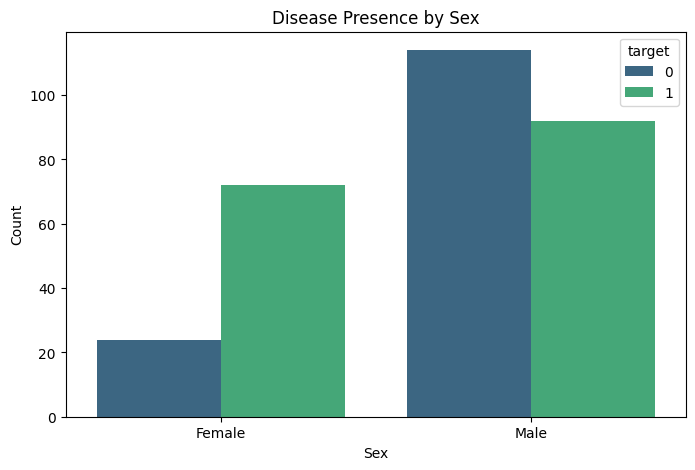

In [5]:
print("\n--- Identifying Potential Bias in the Data ---")

# Let's check for bias related to the 'sex' column
# 0 = female, 1 = male (common encoding, let's assume this)
if 'sex' in X.columns:
    print("\nVisualizing bias related to 'sex' (0=Female, 1=Male):")
    
    # Plotting disease prevalence by sex
    plt.figure(figsize=(8, 5))
    sns.countplot(x='sex', hue=TARGET_COL, data=df, palette='viridis')
    plt.title('Disease Presence by Sex')
    plt.xticks([0, 1], ['Female', 'Male'])
    plt.xlabel('Sex')
    plt.ylabel('Count')
    plt.show()


Visualizing bias related to 'age':


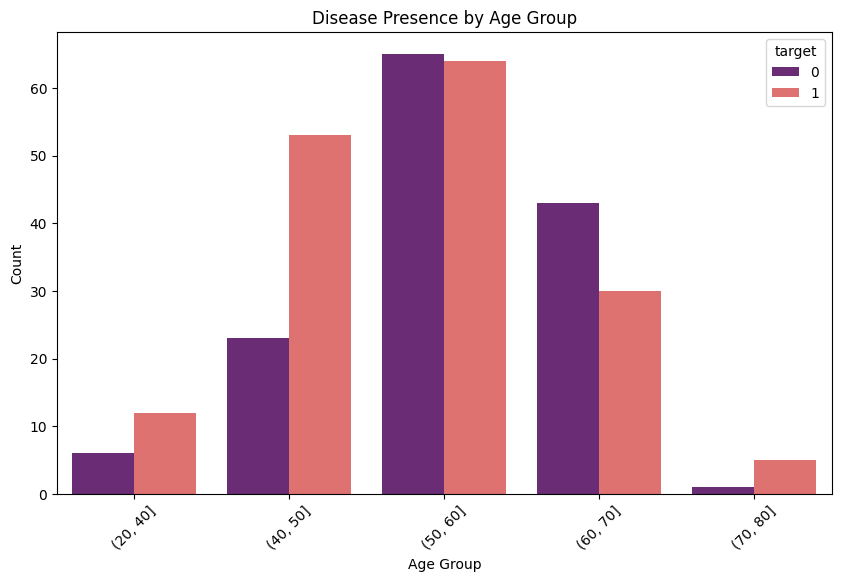

In [6]:
# Let's also check for bias related to 'age'
if 'age' in X.columns:
    print("\nVisualizing bias related to 'age':")
    
    # Creating age bins for easier visualization
    age_bins = pd.cut(df['age'], bins=[20, 40, 50, 60, 70, 80])
    plt.figure(figsize=(10, 6))
    sns.countplot(x=age_bins, hue=TARGET_COL, data=df, palette='magma')
    plt.title('Disease Presence by Age Group')
    plt.xlabel('Age Group')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

# --- 3. Statistical Bias Analysis ---

In [7]:
print("\n--- Statistical Bias Analysis ---")

# Calculate and compare disease prevalence by sex
if 'sex' in df.columns:
    prevalence_by_sex = df.groupby('sex')[TARGET_COL].mean().reset_index()
    prevalence_by_sex['sex'] = prevalence_by_sex['sex'].map({0: 'Female', 1: 'Male'})
    print("Disease Prevalence by Sex:")
    print(prevalence_by_sex)

# Calculate and compare average age of diseased vs. non-diseased individuals
if 'age' in df.columns:
    avg_age_by_target = df.groupby(TARGET_COL)['age'].mean().reset_index()
    print("\nAverage Age of Individuals by Disease Presence:")
    print(avg_age_by_target)
    
# Calculate and compare average cholesterol levels by sex and target
if 'sex' in df.columns and 'chol' in df.columns:
    avg_chol_by_sex = df.groupby('sex')['chol'].mean().reset_index()
    avg_chol_by_sex['sex'] = avg_chol_by_sex['sex'].map({0: 'Female', 1: 'Male'})
    print("\nAverage Cholesterol by Sex:")
    print(avg_chol_by_sex)


--- Statistical Bias Analysis ---
Disease Prevalence by Sex:
      sex    target
0  Female  0.750000
1    Male  0.446602

Average Age of Individuals by Disease Presence:
   target        age
0       0  56.601449
1       1  52.585366

Average Cholesterol by Sex:
      sex        chol
0  Female  261.302083
1    Male  239.601942


# --- 4. Evaluating Model Fairness ---

In [8]:
print("\n--- Evaluating Model Fairness across Groups ---")

# Split the data for model training
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Create a preprocessor for scaling numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), NUMERICAL_FEATURES),
        ('cat', 'passthrough', CATEGORICAL_FEATURES)
    ],
    remainder='passthrough'
)

# Train a model on the full training data
# We use Logistic Regression for this example
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, solver='liblinear'))
])
model_pipeline.fit(X_train, y_train)

# Evaluate model performance for a specific subgroup (e.g., Females)
if 'sex' in X_test.columns:
    print("\nEvaluating model performance for FEMALES:")
    X_test_female = X_test[X_test['sex'] == 0]
    y_test_female = y_test[X_test['sex'] == 0]
    y_pred_female = model_pipeline.predict(X_test_female)
    print(classification_report(y_test_female, y_pred_female))

    # Evaluate model performance for another subgroup (e.g., Males)
    print("\nEvaluating model performance for MALES:")
    X_test_male = X_test[X_test['sex'] == 1]
    y_test_male = y_test[X_test['sex'] == 1]
    y_pred_male = model_pipeline.predict(X_test_male)
    print(classification_report(y_test_male, y_pred_male))


--- Evaluating Model Fairness across Groups ---

Evaluating model performance for FEMALES:
              precision    recall  f1-score   support

           0       0.44      0.67      0.53         6
           1       0.85      0.69      0.76        16

    accuracy                           0.68        22
   macro avg       0.65      0.68      0.65        22
weighted avg       0.74      0.68      0.70        22


Evaluating model performance for MALES:
              precision    recall  f1-score   support

           0       0.81      0.76      0.79        29
           1       0.74      0.80      0.77        25

    accuracy                           0.78        54
   macro avg       0.78      0.78      0.78        54
weighted avg       0.78      0.78      0.78        54



In [9]:
print("\nEthical considerations and bias analysis complete. Compare the metrics for different groups to identify potential unfairness in the model.")
print("The next step is to consider mitigation strategies, such as using `class_weight='balanced'` in your model or exploring specialized fairness-aware algorithms.")


Ethical considerations and bias analysis complete. Compare the metrics for different groups to identify potential unfairness in the model.
The next step is to consider mitigation strategies, such as using `class_weight='balanced'` in your model or exploring specialized fairness-aware algorithms.
